# Step 3 - Learning the price of the first item

*Consider the case in which the assignment of promos is fixed and the price of the second item is fixed and the goal is to learn the optimal price of the first item. Assume that the number of users per class is known as well as the conversion rate associated with the second item. Also assume that the prices are the same for all the classes (assume the same in the following) and that the conversion rates do not change unless specified differently below. Adopt both an upper-confidence bound approach and a Thompson-sampling approach and compare their performance.*

In this scenario we want to learn the optimal price for the first item, assuming to know every other parameter. We will apply and compare a frequentist approach (using **UCB**) with a Baesyan approach (using **TS**).

In [1]:
import mab.Environment
import mab.Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from mab.utilities import *

# Shop and Environment initialization

In this setting we have three shops:
1. **Clairvoyant**: which just naively tests all permutations of possible prices and picks the best one.
2. **TS**: which learns the best possible price using Thompson Sampling.
3. **UCB**: which learns the best possible price using Upper Confidence Bound.

The shops are assumed to know everything except for the price of the first item.

In [2]:
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()
shop_clairvoyant = Shop.Shop()

print(shop_ts.prices1)
print(shop_ts.prices2)

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(None ,env.true_conv2)
shop_ucb.set_conv_rate(None, env.true_conv2)

#Initialize learners
n_arms = len(env.prices1)
shop_ts.set_price_learner('TS', n_arms)
shop_ucb.set_price_learner('UCB', n_arms)


[ 80. 120. 160. 200. 240.]
[100. 150. 200. 250. 300.]


In [3]:
# we have fixed promo fractions
promo_fractions = np.array([[0.3, 0.2, 0.25, 0.25],     # every row is a customer class
                            [0.2, 0.25, 0.30, 0.25],     # every column is a promo type   
                            [0.1, 0.2, 0.3, 0.4],
                            [0.15, 0.15, 0.45, 0.25]])

# we have a fixed price for item 2
price2_index = 2
price2 = env.prices2[price2_index]
max_ind_reward = price2 + max(env.prices1)

## Clairvoyant offline simulation
The Clairvoyant is run offline assuming that it knows every variable.

It will iterate over all the possible choices for the price of the first item and select the one that provides the highest reveune.

In [4]:
#### get clairvoyant price
expected_rewards = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
customers_mean = np.array([25, 25, 25, 25])

for i in range(len(env.prices1)):
    for j in range(env.n_classes):
        expected_reward_from_class = customers_mean[j]*env.prices1[i]*env.true_conv1[j, i]
        for k in range(len(env.discounts)):
            expected_reward_from_class += promo_fractions[j,k]*customers_mean[j]*env.true_conv1[j, i]*price2*env.true_conv2[k, j, price2_index]*(1 - env.discounts[k])
        expected_rewards[i] += expected_reward_from_class


print(env.prices1)
print(expected_rewards)

clairvoyant_price_index = np.argmax(expected_rewards)
clairvoyant_price = env.prices1[clairvoyant_price_index]

[ 80. 120. 160. 200. 240.]
[ 7079.6716888   4169.66792522 15072.11918537 21848.88347115
 15002.88893007]


In [5]:
print(max_ind_reward)
print(clairvoyant_price)

440.0
200.0


## Online Simulation
Here follows the online simulation over a time horizon of one year.

Both learners will choose a price at the beginning of the day, and test it until the end of it.
According to the obtained rewards, they will update some parameters that regulate the price choice, and iterate this behaviour until convergence.

In [6]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []

for day in range(days):
    #Generating customers for the next day
    env.generate_next_day_customers()
    
    #Every shop knows how many customers are coming
    shop_clairvoyant.set_expected_customers(env.customers)
    shop_ts.set_expected_customers(env.customers)
    shop_ucb.set_expected_customers(env.customers)

    #Pull arm from learners 
    chosen_price_ts = shop_ts.price_learner.pull_arm()
    chosen_price_ucb = shop_ucb.price_learner.pull_arm() 


    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)
    


    clairvoyant_per_class = []
    revenue_ts = []
    revenue_ucb = []
    revenue_c = []


    for cust in customers:
        partial_revenue = 0
        cust = int(cust)
        selected_promo = 0
        selected_promo = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions[cust])

        cr1 = shop_clairvoyant.conv1[cust, clairvoyant_price_index]
        cr2 = shop_clairvoyant.conv2[selected_promo, cust, price2_index]
        c_ind_reward = clairvoyant_price*cr1 + price2*cr1*cr2*(1-shop_clairvoyant.discounts[selected_promo])   

        ts_has_bought1 = env.round1(cust, env.prices1[chosen_price_ts])
        ucb_has_bought1 = env.round1(cust, env.prices1[chosen_price_ucb])

        partial_revenue_ts = ts_has_bought1*shop_ts.prices1[chosen_price_ts]
        partial_revenue_ucb = ucb_has_bought1*shop_ucb.prices1[chosen_price_ucb]

        #Check if second item has been bought
        if ts_has_bought1 == 1:
            partial_revenue_ts += price2*shop_ts.conv2[selected_promo, cust, price2_index]*(1-shop_ts.discounts[selected_promo])
        revenue_ts.append(partial_revenue_ts)

        norm_ts = partial_revenue_ts / max_ind_reward
        shop_ts.price_learner.update(chosen_price_ts, norm_ts)
        
        if ucb_has_bought1 == 1:
            partial_revenue_ucb += price2*shop_ucb.conv2[selected_promo, cust, price2_index]*(1-shop_ucb.discounts[selected_promo])
        revenue_ucb.append(partial_revenue_ucb)

        norm_ucb = partial_revenue_ucb / max_ind_reward
        shop_ucb.price_learner.update(chosen_price_ucb, norm_ucb)

        revenue_c.append(c_ind_reward)
    
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(revenue_c))


/home/famorosini/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

501.9697174762114
25326.376236101896


## Results Analysis

As we can see both learners are quite similar, but TS shows slightly better performances. 

Text(0, 0.5, 'Revenue')

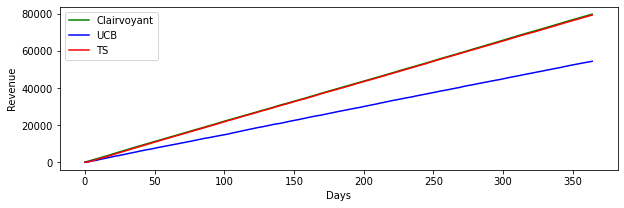

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(u_rewards_per_class_per_day),color='blue',label='UCB')
plt.plot(np.cumsum(ts_rewards_per_class_per_day),color='red',label = 'TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')


Text(0, 0.5, 'Revenue')

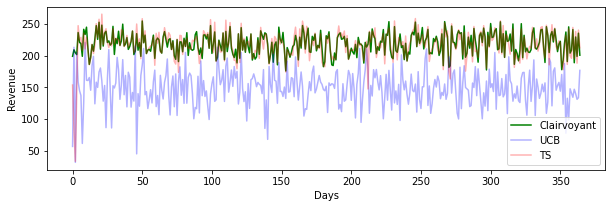

In [9]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(10,3))
plt.plot(clairvoyant_per_class_per_day, color='green',label='Clairvoyant')
plt.plot(u_rewards_per_class_per_day, color='blue', alpha=0.3, label='UCB')
plt.plot(ts_rewards_per_class_per_day, color='red', alpha=0.3, label='TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

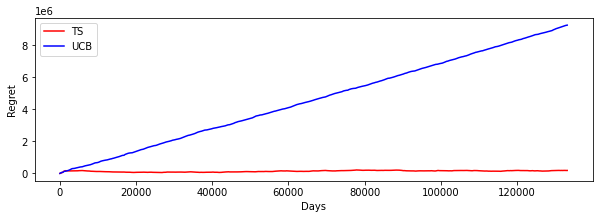

In [10]:
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')